In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Type
from enum import Enum

In [ ]:
from sympy import *
from sympy.parsing.sympy_parser import parse_expr

In [ ]:
class function:
    def __init__(self, func, num_args):
        self.num_args = num_args
        self.x = symbols(f'x0:{num_args}')
        self.origin = parse_expr(func)
        self.lmb = lambdify(self.x, self.origin)
        self.nabla = [lambdify(self.x, diff(self.origin, self.x[i])) for i in range(0, num_args)] # вектор функций производных
        nb = [diff(self.origin, self.x[i]) for i in range(0, num_args)]
        self.hesse = [[lambdify(self.x, diff(nb[i], self.x[j])) for j in range(0, num_args)] for i in range(0, num_args)]
    
    def grad(self, cur_x): # градиент
        cur_x = cur_x.tolist()
        return np.array([f(*cur_x) for f in self.nabla])
    
    def hesse_matrix(self, cur_x): # значение матрицы гессе в точке
        cur_x = cur_x.tolist()
        return np.array([np.array([f(*cur_x) for f in t]) for t in self.hesse])
    
    def eval(self, cur_x): # значение функции в точке
        cur_x = cur_x.tolist()
        return self.lmb(*cur_x)     

In [ ]:
class plot:
    def __init__(self, func, x, y):
        assert func.num_args == 2, 'Only quadratic functions is available'
        
        self.f = func
        self.xlist = np.linspace(*x)
        self.ylist = np.linspace(*y)
        
    def draw(self, history=None, name=''):
        X, Y = np.meshgrid(self.xlist, self.ylist)
        Z = X.copy()
        for i in range(Z.shape[0]):
            for j in range(Z.shape[1]):
                Z[i][j] = self.f.eval(np.array([X[i][j], Y[i][j]]))
        fig,ax=plt.subplots(1,1)
        cp = ax.contourf(X, Y, Z)
        fig.colorbar(cp)
        
        if history is not None:
            plt.plot(history[:,0], history[:,1], '-ok', color='r')
            #for i in range(len(history)):
                #plt.text(history[i][0], history[i][1], f'x{i}')
        
        ax.set_title(name)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        plt.show()

In [ ]:
def golden_ratio_method(l, r, func, eps):
    
    op, v = l.copy(), r - l
    l, r = 0., 1.
    x1, x2 = l + (3 - np.sqrt(5)) / 2 * (r - l), r - (3 - np.sqrt(5)) / 2 * (r - l)
    y1, y2 = func.eval(op + x1 * v), func.eval(op + x2 * v)
    while abs(l - r) > eps:
        if y1 < y2:
            r, x2, y2 = x2, x1, y1
            x1 = l + (3 - np.sqrt(5)) / 2 * (r - l)
            y1 = func.eval(op + x1 * v)
        else:
            l, x1, y1 = x1, x2, y2
            x2 = r - (3 - np.sqrt(5)) / 2 * (r - l)
            y2 = func.eval(op + x2 * v)

    return (r + l) / 2


def fibonacci_method(l, r, func, eps):

    op, v = l.copy(), r - l
    l, r = 0., 1.
    
    array = [0, 1]
    while array[-1] <= (v**2).sum()/eps:
        array.append(array[-1] + array[-2])
    n = len(array) - 3
    if n <= 0:
        return (r + l) / 2

    x1, x2 = l + array[-3] / array[-1] * (r - l), l + array[-2] / array[-1] * (r - l)
    y1, y2 = func.eval(op + x1 * v), func.eval(op + x2 * v)
    l0, r0 = l, r

    for k in range(2, n + 1):
        if y1 < y2:
            r, x2, y2 = x2, x1, y1
            x1 = l + array[n - k + 1] / array[-1] * (r0 - l0)
            y1 = func.eval(op + x1 * v)
        else:
            l, x1, y1 = x1, x2, y2
            x2 = l + array[n - k + 2] / array[-1] * (r0 - l0)
            y2 = func.eval(op + x2 * v)

    return (r + l) / 2


class scheduler_mode(Enum):
    static = 0
    splitting = 1
    golden_ratio = 2
    fibonacci = 3


class scheduler: # класс, определюящий шаг спуска по заданным данным 
    def __init__(self, mode: Type[scheduler_mode]=scheduler_mode.static, **kwargs):
        self.d = kwargs
        self.mode = mode.value
        if self.mode == 0:
            self.step = self.d['step']
        elif self.mode == 1:
            self.step = self.d['step']
            self.divider = self.d['div']
            self.schedule = self.d['schedule']
            self.counter = 0
        elif self.mode == 2:
            self.zero_optimizer = golden_ratio_method
        elif self.mode == 3:
            self.zero_optimizer = fibonacci_method
        
    def make_step(self, x, grad, f, eps): # функция, возвращающая множитель для вектора градиента
        if self.mode == 0:
            return self.step
        elif self.mode == 1:
            if self.counter == self.schedule:
                self.counter = 0
                self.step /= self.divider
            if abs(f.eval(x) - f.eval(grad)) < eps**0.5:
                self.counter += 1
            return self.step
        elif self.mode in [2, 3]:
            return self.zero_optimizer(x, grad, f, eps)
        

def norm_2(vec):
    return sum(vec**2)

In [ ]:
def grad_descent(f, x0=None, scheduler=None, eps=1e-9):
    
    assert scheduler is not None, 'Scheduler argument can not be None'
    
    if x0 is None:
        x0 = np.random.rand(f.num_args) * 20 - 10
        
    cur_x, prev_x = x0.copy(), x0.copy()
    history = [np.hstack((cur_x, f.eval(cur_x)))]
    #print(scheduler.mode)
    
    while True:
        prev_x = cur_x.copy()
        
        grad = f.grad(cur_x)
        step = scheduler.make_step(cur_x, cur_x-grad, f, eps)
        cur_x -= step * grad
        #print(cur_x)
        
        entry = np.hstack((cur_x, f.eval(cur_x)))
        history.append(entry)
        
        if abs(f.eval(cur_x) - f.eval(prev_x)) < eps:
            break
        
    return np.vstack(history)

In [ ]:
def conjugate_grads(f, x0=None, n=None, scheduler=None, eps=1e-9):
    assert scheduler is not None, 'Scheduler argument can not be None'
    
    if n is None:
        n = f.num_args
        
    if x0 is None:
        x0 = np.random.rand(f.num_args) * 20 - 10
        
    cur_x, prev_x = x0.copy(), x0.copy()
    history = [np.hstack((cur_x, f.eval(cur_x)))]
    i = 0
    
    while True:
        prev_x = cur_x.copy()
        
        grad = f.grad(cur_x)
        
        if i == 0 or i == n + 1:
            i = 0
            p = -grad
        else:
            p = -grad + beta * p
            # p - предыдущее направление шага
            # beta - коэффтцтент, с котором пересчитываем новое направление 
        
        step = scheduler.make_step(cur_x, cur_x+p, f, eps)
        cur_x += step * p
        beta = norm_2(f.grad(cur_x)) / norm_2(f.grad(prev_x))
        
        entry = np.hstack((cur_x, f.eval(cur_x)))
        history.append(entry)
            
        if abs(f.eval(cur_x) - f.eval(prev_x)) < eps:
            break
        
        i += 1
            
    return np.vstack(history)

In [ ]:
def conjugate_dirs(f, x0=None, alpha=10, scheduler=None, eps=1e-9):
    assert scheduler is not None, 'Scheduler argument can not be None'
    
    n = f.num_args
        
    if x0 is None:
        x0 = np.random.rand(f.num_args) * 20 - 10
        
    cur_x, prev_x = x0.copy(), x0.copy()
    history = [np.hstack((cur_x, f.eval(cur_x)))]
    tmp = np.zeros(n)
    dirs = []
    for i in range(n):
        t = tmp.copy()
        t[i] = alpha
        dirs.append(t.copy())
        t[i] = -alpha
        dirs.append(t.copy())
    
    while True:
        prev_x = cur_x.copy()
        
        step = [scheduler.make_step(cur_x, cur_x+p, f, eps) for p in dirs]
        ch = np.argmin([f.eval(cur_x+step[i]*dirs[i]) for i in range(2 * n)])
        cur_x += step[ch] * dirs[ch]
        
        entry = np.hstack((cur_x, f.eval(cur_x)))
        history.append(entry)
            
        if abs(f.eval(cur_x) - f.eval(prev_x)) < eps:
            break
            
    return np.vstack(history)

In [ ]:
def newton_method(f, x0=None, scheduler=None, eps=1e-9):
    #assert scheduler is not None, 'Scheduler argument can not be None'
    
    n = f.num_args
        
    if x0 is None:
        x0 = np.random.rand(f.num_args) * 20 - 10
        
    cur_x, prev_x = x0.copy(), x0.copy()
    history = [np.hstack((cur_x, f.eval(cur_x)))]
    
    while True:
        prev_x = cur_x.copy()
        
        p = np.linalg.inv(f.hesse_matrix(x0)).dot(f.grad(x0))
        #print(p)
        
        step = scheduler.make_step(cur_x, cur_x-p, f, eps)
        cur_x -= step * p
        #cur_x -= p
        print(cur_x)
        
        entry = np.hstack((cur_x, f.eval(cur_x)))
        history.append(entry)
            
        if abs(f.eval(cur_x) - f.eval(prev_x)) < eps:
            break
            
    return np.vstack(history)

# Метод градиентного спуска и наискорейшего спуска

In [ ]:
f = function('2*x0**2+5*x1**2+x1*x0', 2)
x0 = np.array([-5., 3.])
#x0 = np.random.rand(f.num_args) * 20 - 10
stepper = [scheduler(scheduler_mode.static, step=1e-5),
           scheduler(scheduler_mode.splitting, step=1e-3, schedule=2, div=10),
           scheduler(scheduler_mode.golden_ratio),
           scheduler(scheduler_mode.fibonacci)]
res = [grad_descent(f, x0=x0.copy(), scheduler=x) for x in stepper]
[len(res[i]) for i in range(len(res))]

[199059, 2132, 18, 18]

# Метод сопряженных градиентов
Поддерживает в качестве scheduler'а только методы одномерной оптимизации


In [ ]:
#x0 = np.array([100., 100., 100.])
stepper = [scheduler(scheduler_mode.golden_ratio),
           scheduler(scheduler_mode.fibonacci)]
res1 = [conjugate_grads(f, x0=x0.copy(), scheduler=x) for x in stepper]
[res1[i][-1] for i in range(len(res1))]

[array([ 2.96996074e-10, -6.44088210e-11,  1.78026650e-19]),
 array([-1.59078804e-10,  2.63009436e-09,  3.42192017e-17])]

# Метод сопряженных направлений
Поддерживает в качестве scheduler'а только методы одномерной оптимизации

In [ ]:
#x0 = np.array([100., 100., 100.])
stepper = [scheduler(scheduler_mode.golden_ratio),
           scheduler(scheduler_mode.fibonacci)]
res2 = [conjugate_dirs(f, x0=x0.copy(), scheduler=x) for x in stepper]
[res2[i][-1] for i in range(len(res2))]

[array([-2.91939561e-07,  1.17223497e-06,  6.69890974e-12]),
 array([-2.92977994e-07,  1.17187615e-06,  6.69480689e-12])]

# Метод Ньютона

In [ ]:
stepper = [scheduler(scheduler_mode.golden_ratio),
           scheduler(scheduler_mode.fibonacci)]
res3 = [newton_method(f, x0=x0.copy(), scheduler=x) for x in stepper]
[res3[i][-1] for i in range(len(res3))]

[-1.59398361e-09  9.56390522e-10]
[-5.24717575e-17  3.86754423e-16]
[-9.37792066e-11  5.62678792e-11]
[ 7.59875513e-16 -1.00653940e-16]


[array([-5.24717575e-17,  3.86754423e-16,  7.33107803e-31]),
 array([ 7.59875513e-16, -1.00653940e-16,  1.12899321e-30])]

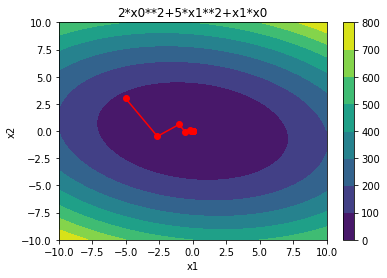

18


In [ ]:
trr = plot(f, (-10, 10, 200), (-10, 10, 200))
history = res[3]
trr.draw(history=history, name='2*x0**2+5*x1**2+x1*x0')
print(len(history))

# Графики

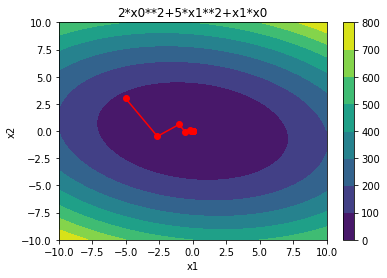

18


In [ ]:
func_const = '2*x0**2+5*x1**2+x1*x0'
ff = function(func_const, 2)
trr = plot(ff, (-10, 10, 200), (-10, 10, 200))
#x0 = np.array([-7.5, 5])
stepper = scheduler(scheduler_mode.fibonacci)
history = grad_descent(ff, x0=x0.copy(), scheduler=stepper)
trr.draw(history=history, name=func_const)
print(len(history))

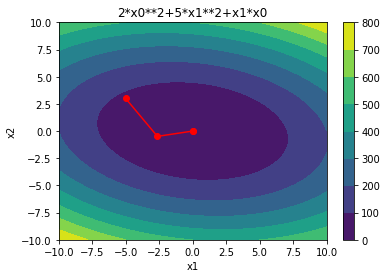

4


In [ ]:
stepper = scheduler(scheduler_mode.golden_ratio)
history = conjugate_grads(ff, x0=x0.copy(), scheduler=stepper)
trr.draw(history=history, name=func_const)
print(len(history))

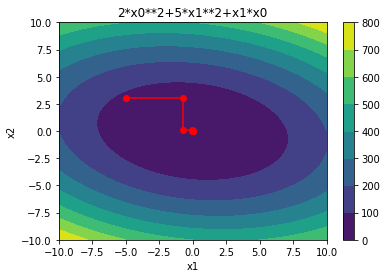

10


In [ ]:
stepper = scheduler(scheduler_mode.golden_ratio)
history = conjugate_dirs(ff, x0=x0.copy(), scheduler=stepper)
trr.draw(history=history, name=func_const)
print(len(history))

[-1.59398361e-09  9.56390522e-10]
[-5.24717575e-17  3.86754423e-16]


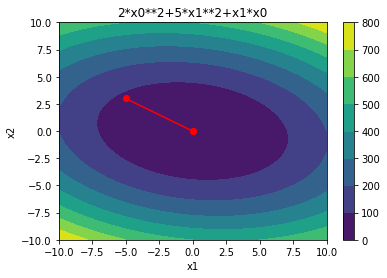

3


In [ ]:
stepper = scheduler(scheduler_mode.golden_ratio)
history = newton_method(ff, x0=x0.copy(), scheduler=stepper, eps=1e-9)
trr.draw(history=history, name=func_const)
print(len(history))

In [ ]:
np.linalg.inv(ff.hesse_matrix(x0))

array([[ 0.25641026, -0.02564103],
       [-0.02564103,  0.1025641 ]])

In [ ]:
def matrix_from_cond(n, cond):
    cond_P = cond    # Condition number
    log_cond_P = np.log(cond_P)
    exp_vec = np.arange(-log_cond_P/4., log_cond_P * (n + 1)/(4 * (n - 1)), log_cond_P/(2.*(n-1)))
    s = np.exp(exp_vec[:n])
    S = np.diag(s)
    U, _ = np.linalg.qr((np.random.rand(n, n) - 5.) * 200)
    V, _ = np.linalg.qr((np.random.rand(n, n) - 5.) * 200)
    P = U.dot(S).dot(V.T)
    P = P.dot(P.T)
    return P

In [ ]:
def matrix_from_cond_(n, cond):
    s = np.array(np.random.rand(n) * (cond - 1) + 1)
    s[0] = 1
    s[1] = k
    S = np.diag(s)
    return S

In [ ]:
ans = np.zeros((10, 10))
for n in range(3, 4):
  x0 = np.array(np.random.rand(n) * 200 - 100, dtype=np.float128)
  p = 0
  for k in np.arange(50, 110, 50):
    A = matrix_from_cond(n, k)
    print(A)
    if np.linalg.cond(A) != k:
      print(n, k, np.linalg.cond(A))

    fx = ""
    for i in range(0, n):
      for j in range(0, n):
        fx = ''.join([fx,"+", str(A[i][j]), "*x", str(i), "*x", str(j)])
    
    f = function(fx, n)
    #print(n)
    #print(fx[1:])
    res = grad_descent(f, x0=x0.copy(), scheduler=scheduler(scheduler_mode.splitting, step=1e-2, schedule=2, div=10))
    ans[n - 2, p] = int(len(res))
    p = p + 1 
print(ans)
    

[[ 1.79275735 -2.44729312  0.72829799]
 [-2.44729312  4.75234143 -2.16815107]
 [ 0.72829799 -2.16815107  1.66739038]]
[[ 5.6257408  -0.91921469 -4.73349665]
 [-0.91921469  0.76914714  0.25444176]
 [-4.73349665  0.25444176  4.70511206]]
3 100 99.99999999999991
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [3032. 4125.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


In [ ]:
import pandas as pd
df1 = pd.DataFrame(np.array(ans, dtype=np.int32)).to_csv(index=False, header=None, sep =";")
print(df1)
print(np.savetxt('output.csv', ans, delimiter=',', fmt='%d'))

5973;5973;5973;5973;5973;5973;5973;5973;5973;5973
5890;5890;5890;5889;5889;5889;5889;5889;5889;5889
5912;5912;5911;5911;5911;6019;5911;5911;5911;5911
5666;4847;4186;4186;4186;4185;5056;4821;4185;4185
6057;6119;6045;6042;6042;6066;6042;6042;6042;6042
5717;4560;4583;4540;4534;5765;4534;4534;4534;4538
5739;5755;5550;5819;5535;5655;5535;5535;5536;5535
6060;5592;5579;5836;5497;5497;5647;5518;5497;5497
5971;5744;5723;5681;5700;5705;5681;5681;5681;5681
6245;6140;6073;6068;6087;6069;6066;6066;6212;6073

None
